# How does social media reflects my life?
- Who did I talked to the most  
- What relationships did I have with my friends and family?
- What kind of words do I use the most?
- Which language did I use?
- How long do I normally stay online on social media?

In [1]:
import datetime
import json
import os
import pickle
import random
import re
import textwrap
from pathlib import Path
from collections import OrderedDict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import warnings
warnings.filterwarnings("ignore")


import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull

import message_helpers as mh

In [2]:
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['font.sans-serif'] = ['Segoe UI Emoji']

In [3]:
pickle_name = "all_convo.pickle"
pickle_path = Path(pickle_name)

In [4]:
punctuation_regex = r"""
               [,.;:-@#?!&$/\(\)\n\*]+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               """
STOP_WORDS = [
        "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "did", "do", "does", "doing", "don", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "http", "https", "i", "i'd", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "just", "me", "more", "most", "my", "myself", "no", "nor", "not", "now", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own", "s", "same", "she", "should", "so", "some", "such", "t", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "were", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "you", "your", "yours", "yourself", "yourselves", "nan", # not a word, accidental cast of NaN
    ]  # https://gist.github.com/sebleier/554280

In [5]:
def parse_obj(obj):
    for key in obj:
        if isinstance(obj[key], str):
            obj[key] = obj[key].encode("latin_1").decode("utf-8")
        elif isinstance(obj[key], list):
            obj[key] = list(
                map(
                    lambda x: x
                    if type(x) != str
                    else x.encode("latin_1").decode("utf-8"),
                    obj[key],
                )
            )
        pass
    return obj


def sumarise_convo(name, data, verbose=False):
    words = {}
    words[name] = data.content.str.cat(sep=" ")
    wordcount = len(words[name].split(" "))

    unique_words = set(words[name].split(" "))

    pool = " ".join([str(x) for x in data.content.to_list()]).lower()
    clean = re.sub(mh.PUNCTUATION_REGEX, " ", pool, flags=re.VERBOSE)
    # and replace it with a single space
    stopped = list(set([w for w in clean.split() if w not in mh.STOP_WORDS]))

    if verbose:
        print(
            f"{name} wrote {wordcount} words ({len(words[name])} characters)"
            f" and used {len(stopped)} different words."
        )
    return {
        "participant": name,
        "wordcount": wordcount,
        "unique_words": len(unique_words),
        "cleaned_unique": len(stopped),
    }


def get_message_length(message):
    if type(message) is str:
        return len(message)
    else:
        return len(str(message))


def replace_typographic_apostrophy(message):
    if type(message) is str:
        return message.replace("’", "'")
    else:
        return message


In [6]:
def load_whole_inbox(rootdir, platform="Facebook"):
    conversations = []
    for d in os.listdir(rootdir):
        conversations.append(d)
    print(f"There are {len(conversations)} conversations to look at from {platform}.")
    # conversations

    convo_df_list = []

    if not pickle_path.is_file():
        for convo in os.listdir(rootdir):
            if ".DS_Store" not in convo:
                for f in os.listdir(os.path.join(rootdir, convo)):
                    try:
                        message_list = []
                        path = os.path.join(os.path.join(rootdir, convo, f))
                        if Path(path).is_file():
                            with open(path, "r") as fb_data:
                                messages = json.load(fb_data, object_hook=parse_obj)
                                message_list.extend(messages["messages"])

                        if len(message_list) != 0:
                            df = pd.DataFrame(message_list)
                            df["source_convo"] = convo
                            df["datetime"] = df.timestamp_ms.apply(
                                lambda x: datetime.datetime.fromtimestamp(x / 1000.0)
                            )

                            if "content" in df.columns:
                                df["message_length"] = df.content.apply(get_message_length)
                                df.content = df.content.apply(
                                    replace_typographic_apostrophy
                                )
                            else:
                                df["message_length"] = 0
                                df["content"] = np.nan

                            df["platform"] = platform

                            convo_df_list.append(df)

                    except Exception as e:
                        print("exception", convo, e)
    return convo_df_list


fb_rootdir = "fb_data/messages/inbox"
fb_convo_df_list = load_whole_inbox(fb_rootdir, platform="Facebook")
ig_rootdir = "insta_data/messages/inbox"
ig_convo_df_list = load_whole_inbox(ig_rootdir, platform="Instagram")
convo_df_list = fb_convo_df_list + ig_convo_df_list
len(convo_df_list)


There are 191 conversations to look at from Facebook.
There are 141 conversations to look at from Instagram.


0

In [7]:
if pickle_path.is_file():
    all_convo_df = pd.read_pickle(pickle_path)
else:
    all_convo_df = pd.concat(convo_df_list, ignore_index=True)
    pd.to_pickle(all_convo_df, pickle_path)
    all_convo_df.sample(10)

In [8]:
def clean_and_stop(content, as_list=False):
    try:
        clean = re.sub(
            mh.PUNCTUATION_REGEX,
            " ",
            content,
            flags=re.VERBOSE,  # and replace it with a single space
        )
        stopped = [w.lower() for w in clean.split() if w.lower() not in mg.STOP_WORDS]
        # print(content, "=>", stopped)
        if as_list:
            return stopped
        else:
            return " ".join(stopped)
    except Exception as e:
        # print(content, e)
        return content


all_convo_df["clean_content"] = all_convo_df.content.apply(clean_and_stop)


In [9]:
print(all_convo_df.shape)
all_convo_df.head(5)

(125857, 21)


,sender_name,timestamp_ms,content,type,is_unsent,source_convo,datetime,message_length,platform,photos,...,ip,call_duration,share,reactions,gifs,videos,audio_files,missed,users,clean_content
0,,1547017013329,넵,Generic,False,nimxf-gelg,2019-01-09 17:56:53.329,1,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,넵
1,장수영,1547016964711,괜찮아요 다음부터 조심하세요~~,Generic,False,nimxf-gelg,2019-01-09 17:56:04.711,17,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,괜찮아요 다음부터 조심하세요~~
2,,1547016938868,찾았습니다... 감사합니다 정말..,Generic,False,nimxf-gelg,2019-01-09 17:55:38.868,19,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,찾았습니다... 감사합니다 정말..
3,,1547016812510,아지금 3층으로가고있어요,Generic,False,nimxf-gelg,2019-01-09 17:53:32.510,13,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,아지금 3층으로가고있어요
4,장수영,1547016791852,찾으셨나요?,Generic,False,nimxf-gelg,2019-01-09 17:53:11.852,6,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,찾으셨나요?


In [10]:
conv_meta = []
for name, data in all_convo_df.groupby("sender_name"):
    conv_meta.append( sumarise_convo(name, data))
meta_df = pd.DataFrame(conv_meta)
meta_df["ratio"] = meta_df.apply(lambda row: row.wordcount / (row.cleaned_unique+1) , axis=1)


# Who did I talked to most?
The graph clearly shows that I talked to Megan Su alot. That is my sister. 
The follow by my high school friend and my other siblings and my old crush. 

Text(0.5, 1.0, 'Ratio of wordcount to unique words count\n(only showing those with word counts over 1k)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


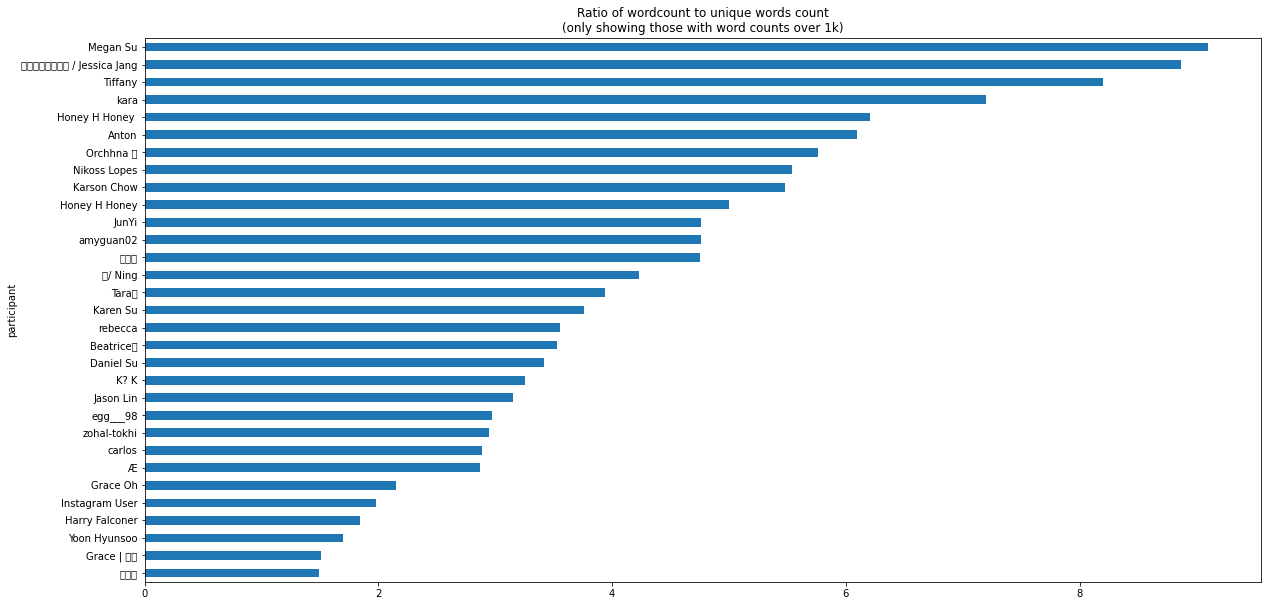

In [11]:
meta_df[meta_df.wordcount>1000].set_index("participant").ratio.sort_values().plot.barh()
plt.title("Ratio of wordcount to unique words count\n(only showing those with word counts over 1k)")

In [12]:
chatty_people = all_convo_df.sender_name.value_counts() > 100
all_convo_df["chatty_people"] = [chatty_people[x] for x in all_convo_df.sender_name]
all_convo_df.sample(5)


,sender_name,timestamp_ms,content,type,is_unsent,source_convo,datetime,message_length,platform,photos,...,call_duration,share,reactions,gifs,videos,audio_files,missed,users,clean_content,chatty_people
380,Yerin Lee,1595581819514,https://us04web.zoom.us/j/75413385874?pwd=VXNJ...,Generic,False,yerinlee_7dwu5zgnfa,2020-07-24 19:10:19.514,74,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://us04web.zoom.us/j/75413385874?pwd=VXNJ...,True
68964,egg___98,1613957487286,Yh hahaha,Generic,False,egg___98_jbaerutioa,2021-02-22 12:31:27.286,9,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yh hahaha,True
36095,장수영,1499930264145,Yea,Generic,False,dabilee_20xcslp4-g,2017-07-13 17:17:44.145,3,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yea,True
39052,장수영,1568786578552,No she didnt,Generic,False,danielsu_p-1lmy2wbq,2019-09-18 16:02:58.552,12,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No she didnt,True
40750,adrian_aa268,1614735882651,Omg I do too,Generic,False,adrian_aa268_qttnwjcasa,2021-03-03 12:44:42.651,12,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Omg I do too,False


In [13]:
def time_to_seconds(dt):
    t = dt.time()
    seconds = (t.hour * 60 + t.minute) * 60 + t.second
    return seconds


all_convo_df["date"] = all_convo_df.datetime.apply(lambda x: x.date())
all_convo_df["time"] = all_convo_df.datetime.apply(lambda x: x.time())
all_convo_df["seconds"] = all_convo_df.datetime.apply(time_to_seconds)
all_convo_df.sample(5)


,sender_name,timestamp_ms,content,type,is_unsent,source_convo,datetime,message_length,platform,photos,...,gifs,videos,audio_files,missed,users,clean_content,chatty_people,date,time,seconds
121390,kara,1613188222239,nooo she's a bit late,Generic,False,oshirioshiri_hvg7ktd4na,2021-02-13 14:50:22.239,21,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,nooo she's a bit late,True,2021-02-13,14:50:22.239000,53422
115024,Tiffany,1618918014588,NaN,Generic,False,oshirioshiri_hvg7ktd4na,2021-04-20 21:26:54.588,3,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,2021-04-20,21:26:54.588000,77214
56121,Nikoss Lopes,1592189675436,Are you going ext tomorrow,Generic,False,nikosslopes_r5obmmdvqg,2020-06-15 12:54:35.436,26,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,Are you going ext tomorrow,True,2020-06-15,12:54:35.436000,46475
47530,장수영 / Jessica Jang,1557736514161,Sorry i don't have that much😭,Generic,False,junyi_ywursnojla,2019-05-13 18:35:14.161,29,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,Sorry i don't have that much😭,True,2019-05-13,18:35:14.161000,66914
94589,kara,1585099498809,SO DO IT,Generic,False,oshirioshiri_hvg7ktd4na,2020-03-25 12:24:58.809,8,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,SO DO IT,True,2020-03-25,12:24:58.809000,44698


In [14]:
plot = sns.lmplot(
    x="date",
    y="seconds",
    data=all_convo_df[all_convo_df["chatty_people"]],
    # data=all_convo_df,
    hue="sender_name",
    fit_reg=False,
    legend=True,
    palette="Set2",
    col="sender_name",
    col_wrap=4,
    scatter_kws=dict(s=80, alpha=0.2),
)


# Importing a single person convo as an example. (Megan)
Shows how much we talked to each other throughout the years. 
I have created wordcloud to show the frequently used words. 

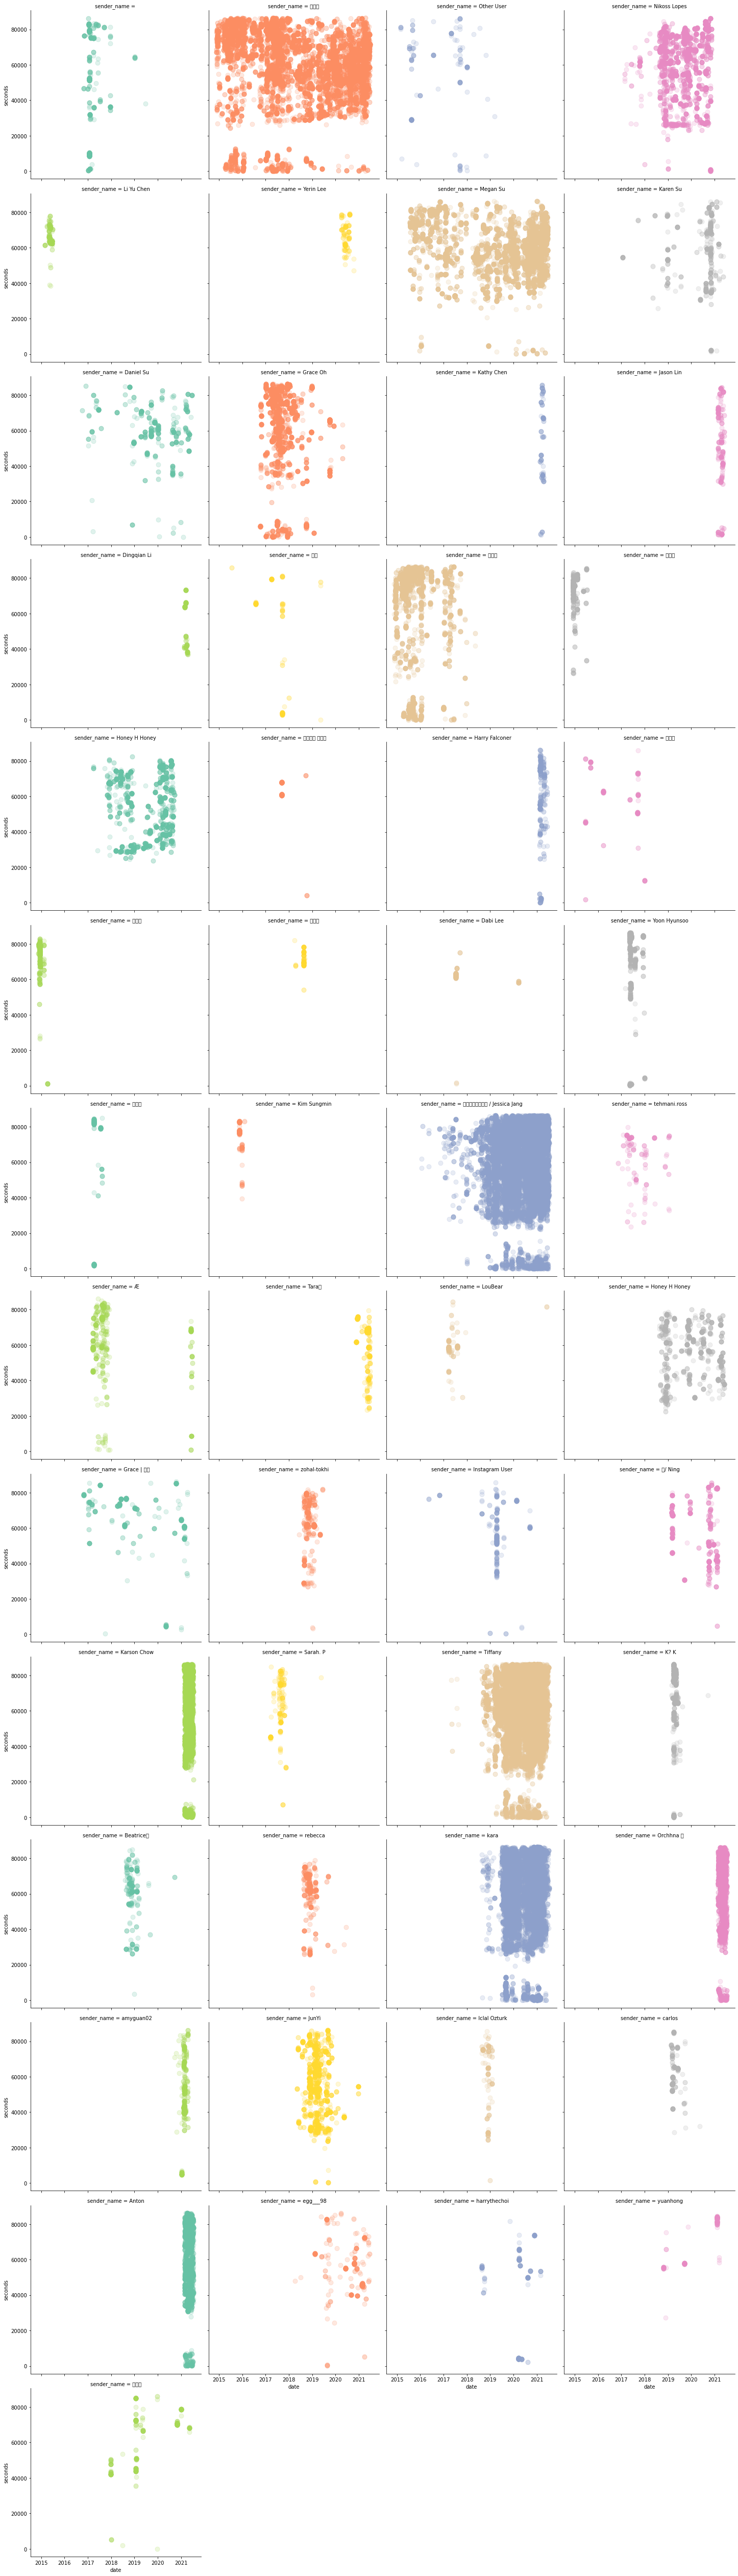

In [15]:
RUN_HEAVY = True 

In [16]:
def parse_obj(obj):
    for key in obj:
        if isinstance(obj[key], str):
            obj[key] = obj[key].encode("latin_1").decode("utf-8")
        elif isinstance(obj[key], list):
            obj[key] = list(
                map(
                    lambda x: x
                    if type(x) != str
                    else x.encode("latin_1").decode("utf-8"),
                    obj[key],
                )
            )
        pass
    return obj


rootdir = "fb_data/messages/inbox/megansu_zepkvzqqpg"

message_list = []
participants = []
for p in os.listdir(rootdir):
    path = os.path.join(rootdir, p)
    if Path(path).is_file():
        with open(path, "r") as insta_data:
            messages = json.load(insta_data, object_hook=parse_obj)
            participants = messages["participants"]
            message_list.extend(messages["messages"])


In [17]:
# message_list = messages["messages"]
df = pd.DataFrame(message_list)
df["datetime"] = df.timestamp_ms.apply(
    lambda x: datetime.datetime.fromtimestamp(x / 1000.0)
)


def get_message_length(message):
    if type(message) is str:
        return len(message)
    else:
        return len(str(message))


def replace_typographic_apostrophy(message):
    if type(message) is str:
        return message.replace("’", "'")
    else:
        return message


df["message_length"] = df.content.apply(get_message_length)
df.content = df.content.apply(replace_typographic_apostrophy)

print(df.shape)
df.sample(5)


(15809, 16)


,sender_name,timestamp_ms,content,type,is_unsent,photos,share,reactions,videos,call_duration,missed,sticker,ip,audio_files,datetime,message_length
13575,Megan Su,1575435000689,Legit cant see anytthing,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-04 15:50:00.689,24
5,장수영,1554102214211,Hahahahahha,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-01 18:03:34.211,11
15654,Megan Su,1555280551962,Dont even like cream,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-15 08:22:31.962,20
1196,장수영,1534144032030,Just womdering,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-08-13 17:07:12.030,14
13661,장수영,1575348300660,Like he link my acc with new card,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-03 15:45:00.660,33


In [18]:
unsent = [m for m in message_list if m["is_unsent"]]
period_string = f"{df.datetime.min():%A %d %B, %Y} and {df.datetime.max():%A %d %B, %Y}"
print (
    f"Conversation between {participants[0]['name']} and {participants[1]['name']}.\n"
    f"Covering the period between {period_string}.\n"
    f"In this period there were {len(message_list)} messages, "
    f"{len([x for x in df.photos if x is not np.nan])} photos, "
    f"{len([x for x in df.videos if x is not np.nan])} videos, "
    # f"{len([x for x in df.audio_files if x is not np.nan])} audio files, "
    f"{len(unsent)} messages were unsent"
)

Conversation between Megan Su and 장수영.
Covering the period between Sunday 26 July, 2015 and Tuesday 22 June, 2021.
In this period there were 15809 messages, 496 photos, 11 videos, 7 messages were unsent


Text(0.5, 1.0, 'Total number of messages sent between Sunday 26 July, 2015 and Tuesday 22 June, 2021')

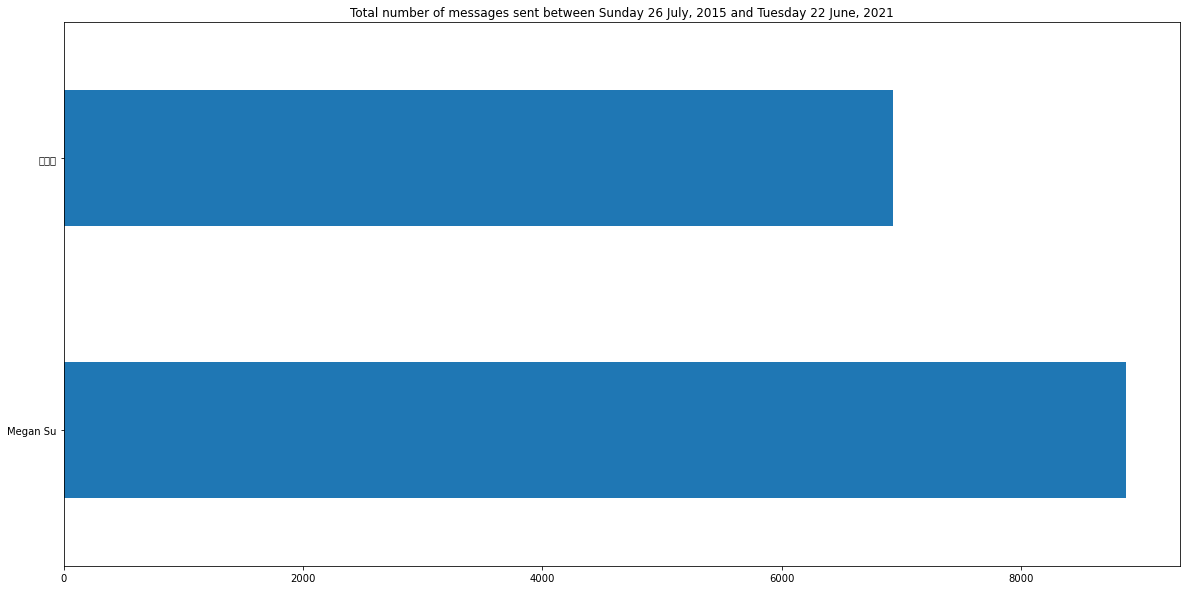

In [19]:
df.sender_name.value_counts().plot.barh()
plt.title(
    f"Total number of messages sent between {period_string}"
)


In [57]:
def sumarise_convo(name, data):
    stop_words = [
        "that's", "i", "i'm", "i'd", "i'll", "it's", "i've", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", 
        "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", 
        "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", 
        "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", 
        "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", 
        "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", 
        "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", 
        "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", 
        "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", 
        "s", "t", "can", "will", "just", "dont", "should", "now", "u", "im", "r", "ur", "n", "yh", "yeh", "Yeah", "nah", "Nope",
        "getting", "going", "ok", "go", "oh", "think", "one", "thats", "already", "see", "still", "like", "get", "gonna", "got", "knew", 
        "wait", "tmw", "maybe", "thought", "said", "need", "ye", "know", "home", "wanna", "tho", "cuz", "tell", "yea", "also", "okey",
        "finished", "cant", "back", "coming", "want", "good", 'didnt', "idk", "today", ""
    ]  # From: https://gist.github.com/sebleier/554280
    words = {}
    words[name] = data.content.str.cat(sep=" ")
    wordcount = len(words[name].split(" "))

    clean_words = [
        x.lower() for x in words[name].split(" ") if x.lower() not in stop_words
    ]
    unique_words = set(words[name].split(" "))
    print(
        f"Between {period_string}, {name} wrote {wordcount} words ({len(words[name])} characters)"
        f" and used {len(unique_words)} different words."
    )
    # print(unique_words)

    word_freq = pd.Series(clean_words).value_counts()
    top = 40
    # print(word_freq.iloc[:top])
    try:
        word_freq.iloc[:top].plot.barh()
        plt.title(f"{name}'s top {top} most used words")
        plt.tight_layout()
        plt.savefig(f"convo_graphs/{name}'s most used words")
        plt.show()
    except Exception as e:
        print(name, e)
    

Between Sunday 26 July, 2015 and Tuesday 22 June, 2021, Megan Su wrote 34855 words (165995 characters) and used 5158 different words.
Megan Su [Errno 2] No such file or directory: "convo_graphs/Megan Su's most used words.png"
Between Sunday 26 July, 2015 and Tuesday 22 June, 2021, 장수영 wrote 25806 words (120063 characters) and used 4183 different words.
장수영 [Errno 2] No such file or directory: "convo_graphs/장수영's most used words.png"


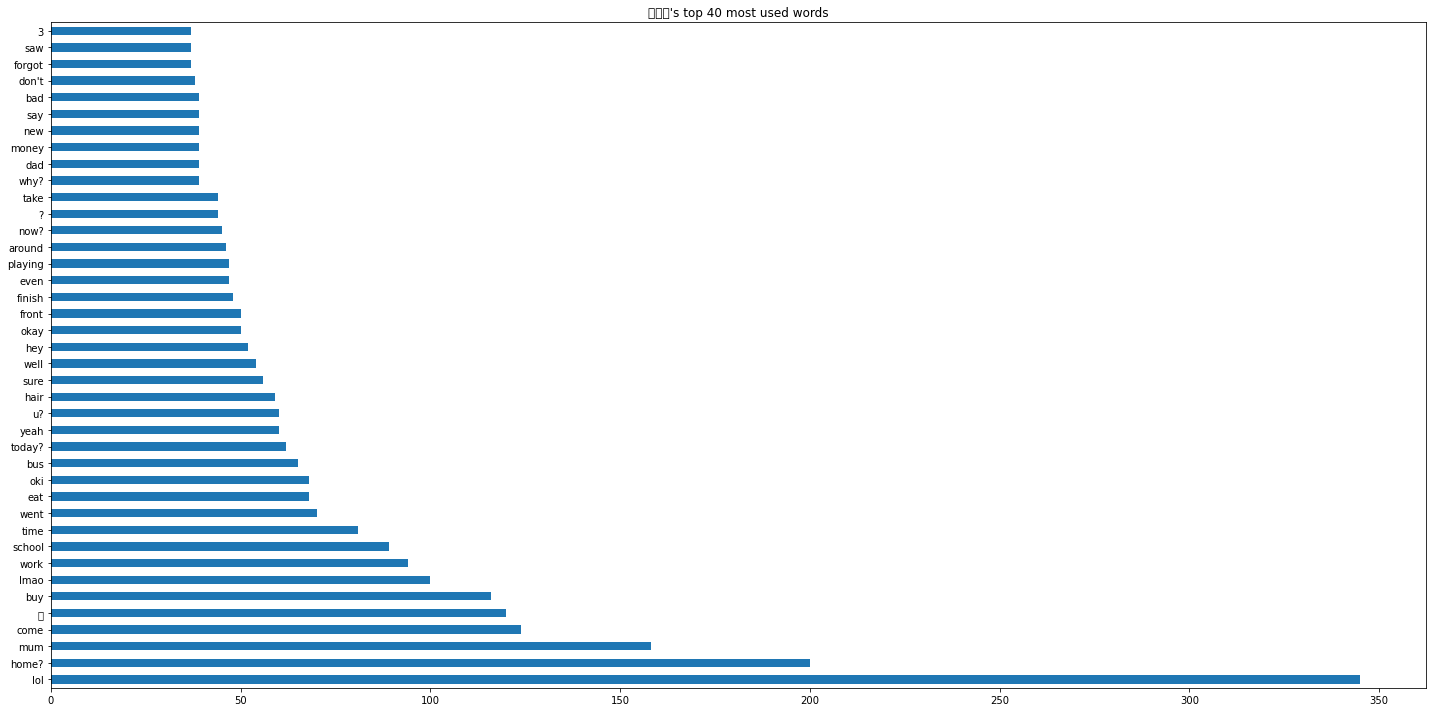

In [58]:
if RUN_HEAVY:
    for name, data in df.groupby("sender_name"):
        sumarise_convo(name, data)

In [22]:
new_df = pd.read_csv("messages.csv")

In [23]:
new_df.head()

,Unnamed: 0,sender_name,timestamp_ms,content,type,is_unsent,photos,share,reactions,videos,call_duration,missed,sticker,ip,audio_files,datetime,message_length,cleanobject
0,0,Megan Su,1.550000e+12,Btw couldnt come cuz i need to poop. Been hold...,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23:39.2,63,Btw couldnt come cuz i need to poop. Been hold...
1,1,장수영,1.550000e+12,Kk,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04:07.4,2,Kk
2,2,Megan Su,1.550000e+12,Cya,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04:03.5,3,Cya
3,3,Megan Su,1.550000e+12,Anyways getting motion sick,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04:01.1,27,Anyways getting motion sick
4,4,장수영,1.550000e+12,Yeh,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03:37.0,3,Yeh


In [24]:
words = new_df['content']
words


0        Btw couldnt come cuz i need to poop. Been hold...
1                                                       Kk
2                                                      Cya
3                              Anyways getting motion sick
4                                                      Yeh
                               ...                        
15776                           Hey im going to fisher lib
15777                                                 3:30
15778                                                 soon
15779                             What time u coming home?
15780                                                  Hey
Name: content, Length: 15781, dtype: object

In [25]:
list_of_words = words.to_list()



In [26]:
text = ','.join(str(x) for x in list_of_words)

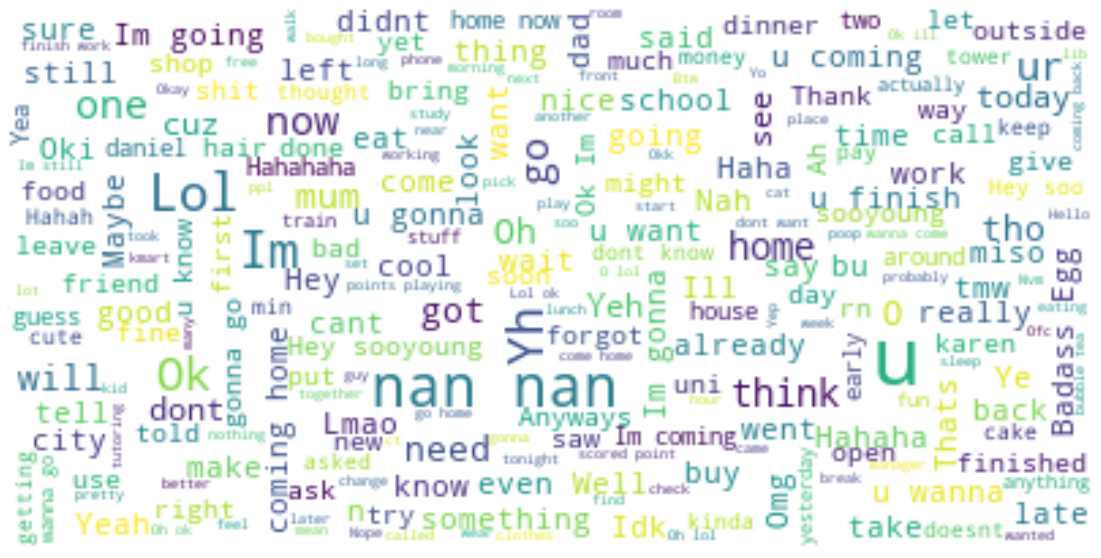

In [33]:
wordcloud = WordCloud(background_color="white",margin=2, min_font_size= 5, max_font_size=30, max_words= 100000, min_word_length=0,).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Add a wordcloud here 

Also, these data shows the change in my preferred language over time. from korean to english

In [ ]:
def has_korean(message):
    try:
        regex = r"[\uac00-\ud7af]|[\u1100-\u11ff]|[\u3130-\u318f]|[\ua960-\ua97f]|[\ud7b0-\ud7ff]"
        matches = re.match(regex, message)
        return matches is not None
    except:
        return False

print(has_korean("hello"))
print(has_korean("장수영"))
all_convo_df["isK"] = all_convo_df.content.apply(has_korean)
all_convo_df.sample(5)

False
True


,sender_name,timestamp_ms,content,type,is_unsent,source_convo,datetime,message_length,platform,photos,...,videos,audio_files,missed,users,clean_content,chatty_people,date,time,seconds,isK
123713,carlos,1559462098610,Topic,Generic,False,fktards_gh7naf69eg,2019-06-02 17:54:58.610,5,Instagram,NaN,...,NaN,NaN,NaN,NaN,Topic,True,2019-06-02,17:54:58.610000,64498,False
55831,Nikoss Lopes,1597323765628,I only did maths n eng,Generic,False,nikosslopes_r5obmmdvqg,2020-08-13 23:02:45.628,22,Instagram,NaN,...,NaN,NaN,NaN,NaN,I only did maths n eng,True,2020-08-13,23:02:45.628000,82965,False
125240,장수영 / Jessica Jang,1616907861173,We had to move back inside,Generic,False,karensu_nhvvhzpl5g,2021-03-28 16:04:21.173,26,Instagram,NaN,...,NaN,NaN,NaN,NaN,We had to move back inside,True,2021-03-28,16:04:21.173000,57861,False
70103,Honey H Honey,1544174087065,You so pretty but you will look prettier with ...,Generic,False,girlschitchat_h1crr4h7xq,2018-12-07 20:14:47.065,75,Instagram,NaN,...,NaN,NaN,NaN,NaN,You so pretty but you will look prettier with ...,True,2018-12-07,20:14:47.065000,72887,False
121139,장수영 / Jessica Jang,1613340945838,NaN,Generic,False,oshirioshiri_hvg7ktd4na,2021-02-15 09:15:45.838,3,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,True,2021-02-15,09:15:45.838000,33345,False


Text(0.5, 1.0, 'Korean messages through out the years')

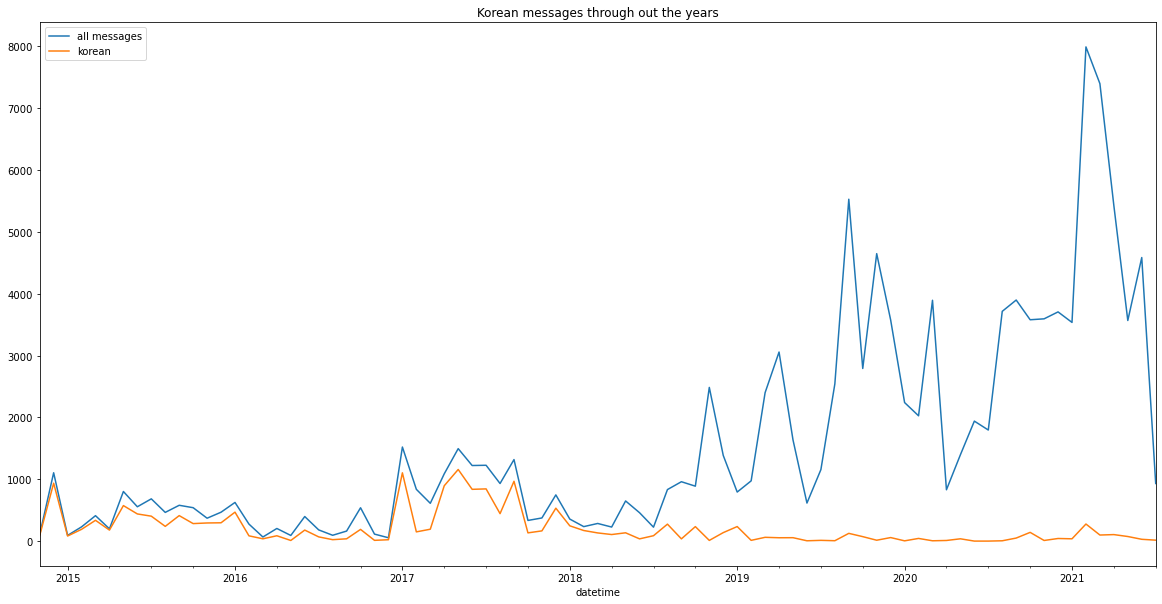

In [ ]:
all_convo_df.set_index("datetime").groupby(pd.Grouper(freq="M")).count().sender_name.plot(label = "all messages")
all_convo_df[all_convo_df.isK].set_index("datetime").groupby(pd.Grouper(freq="M")).count().sender_name.plot(label = "korean")
plt.legend()
plt.title("Korean messages through out the years")

# Finally, it shows how long I was online on social media throughout the years
This can also help determine my approzimate sleep time by looking at the gap between the populated dots 
- Put facebook and instagram data together. 

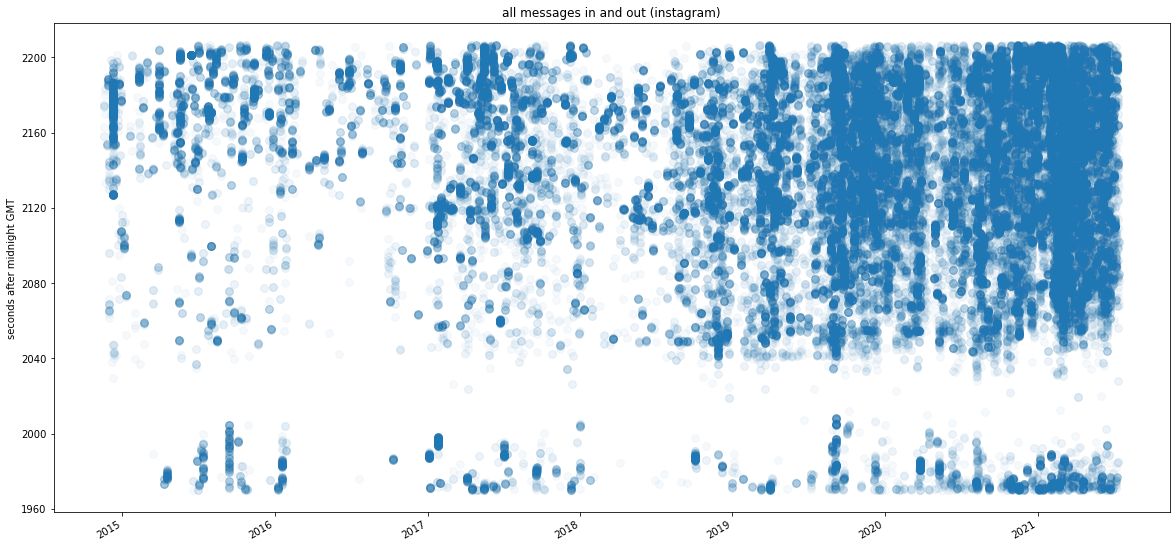

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(
    all_convo_df.date, all_convo_df.seconds, s=60, alpha=0.04
)  # , c=df.sender_name.astype('category').cat.codes)
ax.yaxis_date()
fig.autofmt_xdate()
plt.title("all messages in and out (instagram)")
plt.ylabel("seconds after midnight GMT")

plt.show()


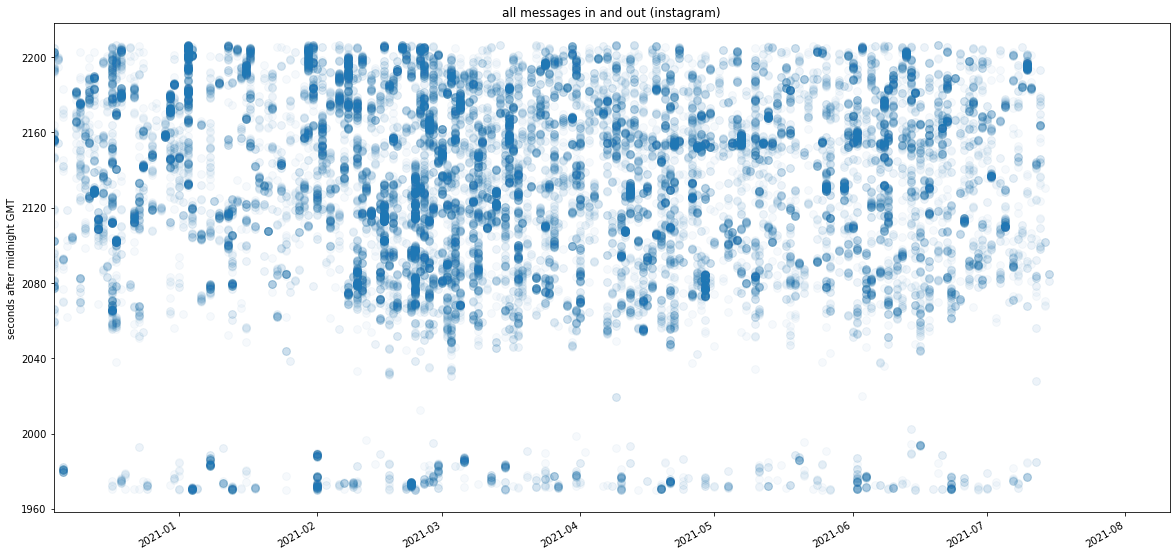

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(
    all_convo_df.date, all_convo_df.seconds, s=60, alpha=0.04
)  # , c=df.sender_name.astype('category').cat.codes)
ax.yaxis_date()
fig.autofmt_xdate()
plt.title("all messages in and out (instagram)")
plt.ylabel("seconds after midnight GMT")
#plt.xlim(["2020-01-01", "2021-08-01"])
plt.xlim(18600, 18850)
plt.show()

In [ ]:
data = all_convo_df[all_convo_df.sender_name != "장수영"]
data = data[data.chatty_people]
print(data.shape)
data.sample(3)


(108105, 26)


,sender_name,timestamp_ms,content,type,is_unsent,source_convo,datetime,message_length,platform,photos,...,videos,audio_files,missed,users,clean_content,chatty_people,date,time,seconds,isK
48482,JunYi,1549750427203,but i have to change bus,Generic,False,junyi_ywursnojla,2019-02-10 09:13:47.203,24,Instagram,NaN,...,NaN,NaN,NaN,NaN,but i have to change bus,True,2019-02-10,09:13:47.203000,33227,False
78963,Tiffany,1609320601700,ANYWAYS,Generic,False,oshirioshiri_hvg7ktd4na,2020-12-30 20:30:01.700,7,Instagram,NaN,...,NaN,NaN,NaN,NaN,ANYWAYS,True,2020-12-30,20:30:01.700000,73801,False
98459,Tiffany,1580185913323,NaN,Generic,False,oshirioshiri_hvg7ktd4na,2020-01-28 15:31:53.323,3,Instagram,NaN,...,NaN,NaN,NaN,NaN,NaN,True,2020-01-28,15:31:53.323000,55913,False


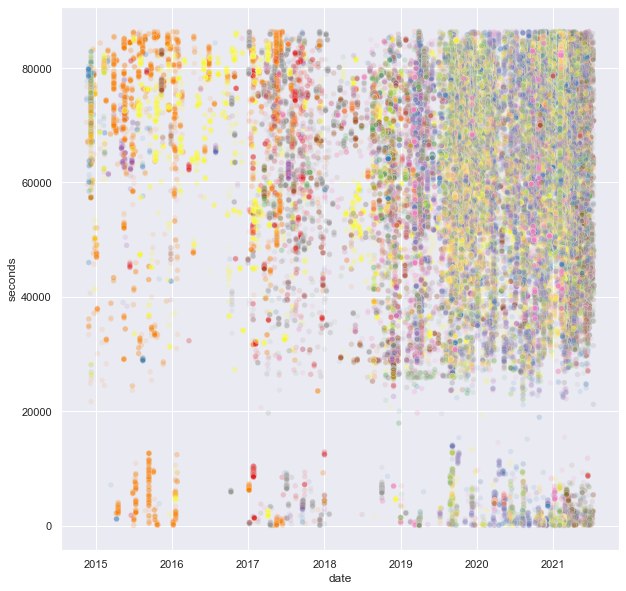

In [ ]:
sns.set(rc={"figure.figsize": (10, 10)})
fig, ax = plt.subplots()
g = sns.scatterplot(
    x="date",
    y="seconds",
    data=data,
    hue="sender_name",
    legend=False,
    palette="Set1",
    s=30,
    alpha=0.1,
    ax=ax,
)
# g.legend(bbox_to_anchor=(1.5, 1))